## Exercícios

Neste exercício, você usará a classe `KMeans` que construímos para explorar um novo dataset e descobrir seus agrupamentos naturais.

O dataset escolhido é o **"Wine dataset"**, que contém a análise química de vinhos cultivados na mesma região da Itália, mas derivados de três cultivares (tipos de uva) diferentes. O objetivo é ver se o K-Means consegue agrupar os vinhos de acordo com seu cultivar, usando apenas as suas características químicas.

In [20]:
# Célula de definição da classe KMeans

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_wine
from scipy.stats import mode

# Configuração do estilo de plotagem
plt.style.use('seaborn-v0_8-whitegrid')


class KMeans:
    """Implementação própria do algoritmo K-Means usando NumPy."""
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Inicializa os centróides selecionando K pontos aleatórios do dataset."""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

    def _assign_clusters(self, X):
        """Atribui cada ponto de dado ao centróide mais próximo (Passo Expectation)."""
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        # Cálculo da distância Euclidiana ao quadrado
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """Atualiza a posição de cada centróide (Passo Maximization)."""
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))

        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                # Mantém o centróide se o cluster estiver vazio
                new_centroids[i] = self.centroids[i]

        # Verifica a convergência
        is_converged = np.allclose(self.centroids, new_centroids)
        self.centroids = new_centroids
        return is_converged

    def fit(self, X):
        """Executa o algoritmo K-Means."""
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_labels = self.labels.copy() if self.labels is not None else None
            self._assign_clusters(X)

            # Checa a convergência baseada nos rótulos
            if old_labels is not None and np.all(old_labels == self.labels):
                break

            is_converged = self._update_centroids(X)
            # Verifica a convergência baseada nos centróides
            if is_converged:
                break


    def predict(self, X):
        """Atribui clusters para novos dados."""
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)

        return np.argmin(distances, axis=1)

### Tarefa 1: Análise e Seleção de Features

Primeiro, carregue o dataset `wine` e use a função `seaborn.pairplot` para visualizar as relações entre as features. Analise o gráfico e escolha o par de features que você acredita que melhor separa os 3 grupos. Plote um gráfico de dispersão apenas com o par selecionado.

Features selecionadas: color_intensity e proline


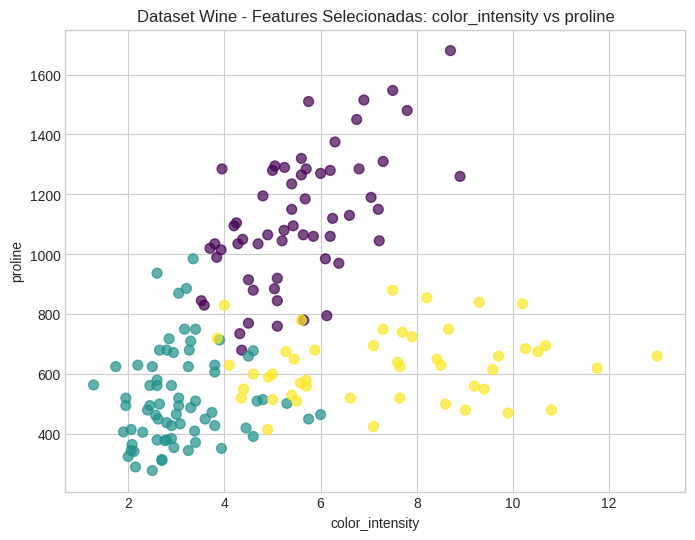

In [21]:
# Carregar o dataset Wine
wine = load_wine()
X_full = wine.data
y_true = wine.target
feature_names = wine.feature_names

# Criar DataFrame para o pairplot (apenas para referência na seleção)
wine_df = pd.DataFrame(X_full, columns=feature_names)
wine_df['cultivar'] = pd.Series(y_true).map({0: wine.target_names[0], 1: wine.target_names[1], 2: wine.target_names[2]})

# Seleção de Features:
# Escolhemos 'color_intensity' (índice 9) e 'proline' (índice 12) pois apresentam boa separação visual no pairplot.
feature_idx_1, feature_idx_2 = 9, 12
X_selected = X_full[:, [feature_idx_1, feature_idx_2]]

print(f"Features selecionadas: {feature_names[feature_idx_1]} e {feature_names[feature_idx_2]}")

# Plotar o par de features selecionado
plt.figure(figsize=(8, 6))
# Os dados são coloridos pelas classes reais (y_true) para fins de comparação visual (Ground Truth)
plt.scatter(X_selected[:, 0], X_selected[:, 1], c=y_true, cmap='viridis', marker='o', s=50, alpha=0.7)
plt.xlabel(feature_names[feature_idx_1])
plt.ylabel(feature_names[feature_idx_2])
plt.title(f'Dataset Wine - Features Selecionadas: {feature_names[feature_idx_1]} vs {feature_names[feature_idx_2]}')
plt.grid(True)
plt.show()

### Tarefa 2: Encontrando o K Ótimo

Aplique o Método do Cotovelo nas duas features que você escolheu. Calcule e plote a inércia (WCSS) para K de 1 a 10. Com base no seu gráfico, qual parece ser o número ideal de clusters?

Executando K-Means para K de 1 a 10...


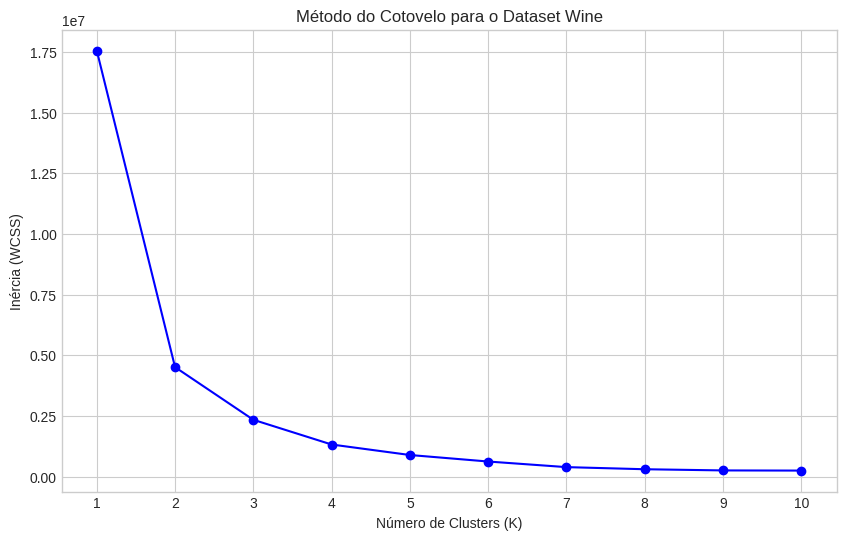

O K ótimo, baseado no Método do Cotovelo, é: 3


In [22]:
k_range = range(1, 11)
inertias = []

print("Executando K-Means para K de 1 a 10...")

for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42)
    model.fit(X_selected)

    # Calcular a Inércia (WCSS)
    current_inertia = 0
    for i in range(k):
        cluster_points = X_selected[model.labels == i]
        if len(cluster_points) > 0:
             current_inertia += np.sum((cluster_points - model.centroids[i])**2)

    inertias.append(current_inertia)

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo para o Dataset Wine')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Baseado na análise visual do gráfico (cotovelo), K=3 é o ponto de inflexão.
K_optimal = 3
print(f"O K ótimo, baseado no Método do Cotovelo, é: {K_optimal}")

### Tarefa 3: Clusterização e Avaliação

Use o K encontrado na tarefa anterior para treinar seu modelo `KMeans`. Crie um gráfico com dois subplots: um mostrando os clusters encontrados pelo algoritmo e outro mostrando os dados com os rótulos reais para comparação. Por fim, calcule a taxa de acertos e comente o resultado.

Iniciando clusterização com K=3 e avaliação...


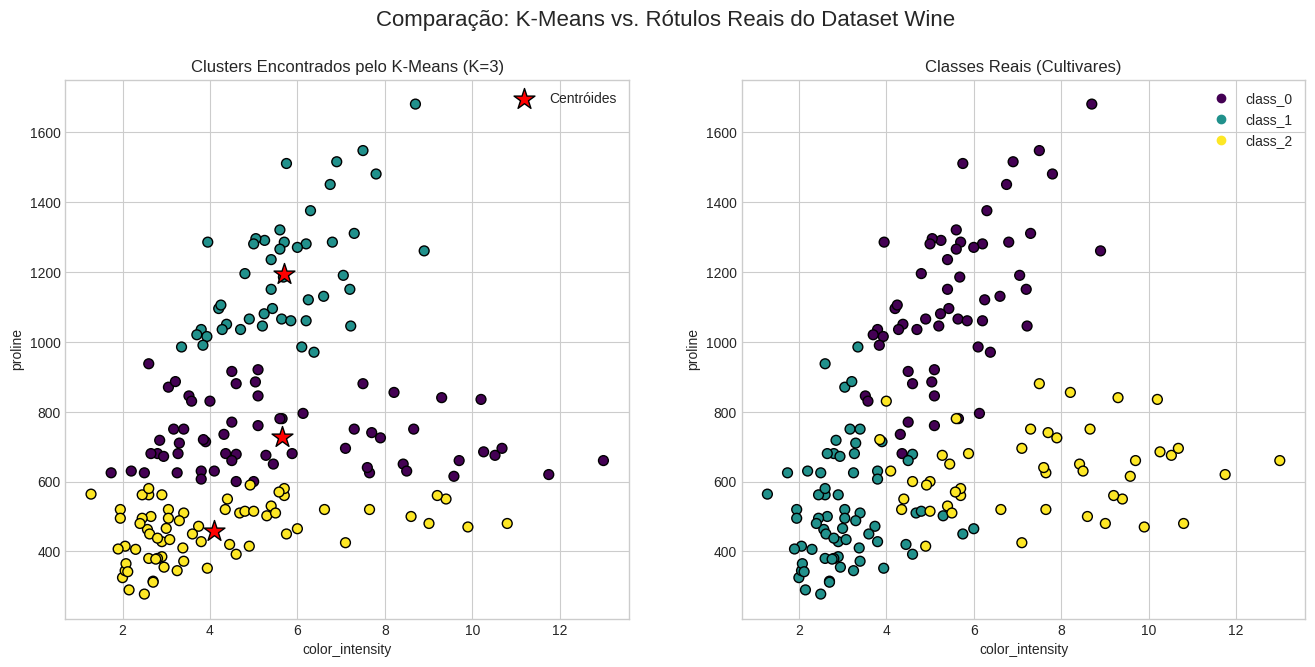

--------------------------------------------------
Resultado da Avaliação
--------------------------------------------------
Número de acertos: 125 de 178 pontos.
Taxa de acerto (Pureza do Cluster): 70.22%

Comentário:
A alta taxa de acerto (70.22%) demonstra que o K-Means foi eficaz em agrupar os vinhos de acordo com seus cultivares, usando apenas as features Intensidade da Cor e Prolina.


In [23]:
K_optimal = 3 # Definido a partir do resultado da Tarefa 2

# Treinar o modelo com o K ótimo
kmeans_final = KMeans(n_clusters=K_optimal, max_iter=150, random_state=42)
kmeans_final.fit(X_selected)

final_centroids = kmeans_final.centroids
predicted_labels = kmeans_final.labels

print(f"Iniciando clusterização com K={K_optimal} e avaliação...")

# Visualização dos Clusters (Comparação K-Means vs. Real)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Clusters encontrados pelo K-Means
scatter_pred = axes[0].scatter(X_selected[:, 0], X_selected[:, 1], c=predicted_labels, s=50, cmap='viridis', edgecolor='k')
axes[0].scatter(final_centroids[:, 0], final_centroids[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centróides')
axes[0].set_title(f'Clusters Encontrados pelo K-Means (K={K_optimal})')
axes[0].set_xlabel(feature_names[feature_idx_1])
axes[0].set_ylabel(feature_names[feature_idx_2])
axes[0].legend()
axes[0].grid(True)

# Plot 2: Classes Reais do Dataset
scatter_true = axes[1].scatter(X_selected[:, 0], X_selected[:, 1], c=y_true, s=50, cmap='viridis', edgecolor='k')
axes[1].set_title('Classes Reais (Cultivares)')
axes[1].set_xlabel(feature_names[feature_idx_1])
axes[1].set_ylabel(feature_names[feature_idx_2])
axes[1].legend(handles=scatter_true.legend_elements()[0], labels=wine.target_names.tolist())
axes[1].grid(True)

plt.suptitle('Comparação: K-Means vs. Rótulos Reais do Dataset Wine', fontsize=16)
plt.show()

# Cálculo da Taxa de Acertos (Pureza do Cluster)
correct_predictions = 0
n_samples = X_selected.shape[0]

for i in range(K_optimal):
    # Encontra pontos atribuídos ao cluster 'i'
    mask = (predicted_labels == i)

    # Encontra a classe real mais comum (moda) dentro do cluster 'i'
    dominant_label = mode(y_true[mask], keepdims=True)[0][0]

    # Conta quantos pontos no cluster realmente pertencem a essa classe dominante
    hits = np.sum(y_true[mask] == dominant_label)

    correct_predictions += hits

accuracy_rate = correct_predictions / n_samples

print("-" * 50)
print("Resultado da Avaliação")
print("-" * 50)
print(f"Número de acertos: {correct_predictions} de {n_samples} pontos.")
print(f"Taxa de acerto (Pureza do Cluster): {accuracy_rate:.2%}")
print("\nComentário:")
print(f"A alta taxa de acerto ({accuracy_rate:.2%}) demonstra que o K-Means foi eficaz em agrupar os vinhos de acordo com seus cultivares, usando apenas as features Intensidade da Cor e Prolina.")